In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
!wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2023-04-27 14:41:56--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.138.128.8, 108.138.128.34, 108.138.128.23, ...
Connecting to segment-anything.com (segment-anything.com)|108.138.128.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K   411KB/s    in 0.5s    

2023-04-27 14:41:58 (411 KB/s) - ‘dog.jpg’ saved [221810/221810]



In [38]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")


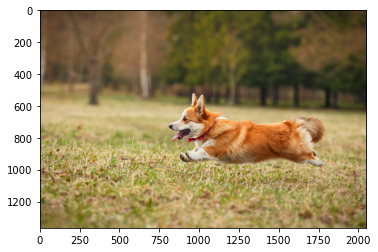

In [39]:
plt.imshow(img.permute(1, 2, 0))

In [40]:
# Normalize the image
img = img / 255.0

In [41]:
img.shape


torch.Size([3, 1365, 2048])

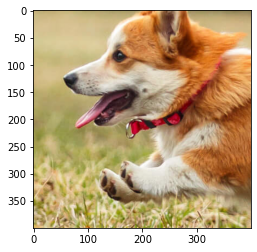

In [42]:
# Take a random 224x224 crop of the image
crop = torchvision.transforms.functional.crop(img, 600, 750, 400, 400)


# Plot the crop
plt.imshow(crop.permute(1, 2, 0))

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape

# Create a 2D grid of (x,y) coordinates
x_coords = torch.arange(width).repeat(height, 1)
y_coords = torch.arange(height).repeat(width, 1).t()
x_coords = x_coords.reshape(-1)
y_coords = y_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([x_coords, y_coords], dim=1).float()

# Move X to GPU if available
X = X.to(device)

In [45]:
num_xy = height * width
num_xy

160000

In [46]:
X.shape, X

(torch.Size([160000, 2]),
 tensor([[  0.,   0.],
         [  1.,   0.],
         [  2.,   0.],
         ...,
         [397., 399.],
         [398., 399.],
         [399., 399.]], device='cuda:0'))

In [52]:
# Extract pixel values from image tensor
pixel_values = crop.reshape(num_channels, -1).float().to(device)

# Transpose the pixel values to be (num_xy, num_channels)
pixel_values = pixel_values.transpose(0, 1)

y = pixel_values.to(device)

In [57]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)

In [72]:
# Training loop function to train the model
# X: (num_xy, 2) tensor of (x, y) coordinates
# y: (num_xy, 3) tensor of (r, g, b) pixel values
# model: MLP model
# lr: learning rate
# epochs: number of epochs to train for
# bs: batch size
# print_every: print loss every print_every epochs
# Logs losses

def train(X, y, model, lr=0.01, epochs=1000, bs=1000, print_every=100):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        # Get a random batch of (x, y) coordinates
        idxs = torch.randperm(num_xy)[:bs]
        batch_X = X[idxs]
        batch_y = y[idxs]

        # Predict the (r, g, b) values
        pred_y = model(batch_X)

        # Compute the loss
        loss = criterion(pred_y, batch_y)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Print loss every print_every epochs
        if epoch % print_every == 0:
            print(f"Epoch {epoch} loss: {loss.item()}")
    return losses

In [73]:
m1 = MLP()
m1 = m1.to(device)
losses_mlp = train(X, y, m1, lr=0.001, epochs=10000, bs=1000, print_every=500)

Epoch 0 loss: 1.0679893493652344
Epoch 500 loss: 0.02556886523962021
Epoch 1000 loss: 0.02347256988286972
Epoch 1500 loss: 0.02184450812637806
Epoch 2000 loss: 0.0214732363820076
Epoch 2500 loss: 0.021007681265473366
Epoch 3000 loss: 0.016363944858312607
Epoch 3500 loss: 0.01607414335012436
Epoch 4000 loss: 0.017359109595417976
Epoch 4500 loss: 0.014642925933003426
Epoch 5000 loss: 0.013753218576312065
Epoch 5500 loss: 0.013786138035356998
Epoch 6000 loss: 0.011726140044629574
Epoch 6500 loss: 0.012334194965660572
Epoch 7000 loss: 0.012622413225471973
Epoch 7500 loss: 0.011296451091766357
Epoch 8000 loss: 0.010620768181979656
Epoch 8500 loss: 0.011167907156050205
Epoch 9000 loss: 0.010226663202047348
Epoch 9500 loss: 0.011250185780227184


In [78]:
def plot_image(model):
    # Predict the (r, g, b) values
    pred_y = model(X)

    # Reshape the predictions to be (3, height, width)
    pred_y = pred_y.transpose(0, 1).reshape(num_channels, height, width)

    # plot the image
    plt.imshow(pred_y.permute(1, 2, 0).detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


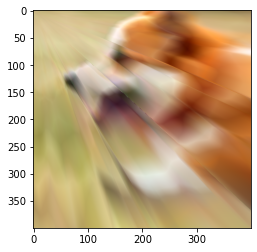

In [79]:
plot_image(m1)

In [80]:
# Create a MLP with 5 hidden layers with 256 neurons each and sine activations.
# Input is (x, y) and output is (r, g, b)

class MLP_sin(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        x = torch.sin(self.fc3(x))
        x = torch.sin(self.fc4(x))
        x = torch.sin(self.fc5(x))
        return self.fc6(x)

In [81]:
m2 = MLP_sin()
m2 = m2.to(device)
losses_mlp_sin = train(X, y, m2, lr=0.001, epochs=4000, bs=1000, print_every=500)

Epoch 0 loss: 0.4115862250328064
Epoch 500 loss: 0.034314047545194626
Epoch 1000 loss: 0.026829784736037254
Epoch 1500 loss: 0.014838427305221558
Epoch 2000 loss: 0.004438335541635752
Epoch 2500 loss: 0.0023151382338255644
Epoch 3000 loss: 0.0017136678798124194
Epoch 3500 loss: 0.0012063680915161967


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


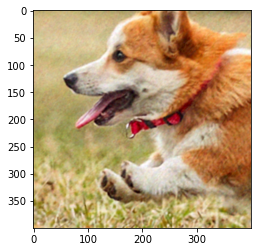

In [82]:
plot_image(m2)

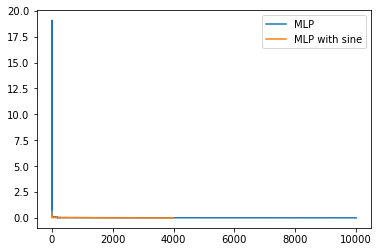

In [83]:
# Compare the training losses of the two models
plt.plot(losses_mlp, label="MLP")
plt.plot(losses_mlp_sin, label="MLP with sine")
plt.legend()